In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

output_directory = '/home/marco/DataspellProjects/thesis/output/knn/ST001937/'

palette = sns.color_palette(["#2176AB", "#F97662", "#FFBF00", "#50C878", "#B284BE"])
#create a gradient color palette 
gradient_palette = sns.blend_palette(['#ECF7FE', palette[0]], as_cmap=True)
sns.set(style="whitegrid", font_scale=1.5)
sns.set_palette(palette)

df = pd.read_csv('../../../data/ST001937_bm.csv')
df.describe()

,"1,3,5(10)-estratrien-3,6- beta-17-beta-triol","1,5-anhydroglucitol",17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-1,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-2,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-3,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-4,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-5,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-6,1-hexadecanol,1-hydroxyanthraquinone prod,...,tyrosine-2,urea-1,urea-2,urea-3,urea-4,uridine,valine,xanthine,xanthosine,Phenotypes
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.060028,0.081831,0.121458,0.069002,0.153339,-0.028114,0.146952,0.141551,0.185913,0.117030,...,0.183951,0.187359,0.124397,0.203862,0.048426,0.036753,0.098137,0.052093,0.053100,0.500000
std,1.149557,1.157614,1.158775,1.177830,1.145922,1.348227,1.291587,1.301322,1.262072,1.132816,...,1.277060,1.208034,1.178328,1.225597,1.107458,1.237427,1.376308,1.179492,1.101968,0.500417
min,-10.056505,-7.753742,-1.103028,-2.246114,-0.763127,-16.350768,-0.914859,-1.005143,-1.729810,-1.077471,...,-1.465182,-1.484441,-1.278308,-1.639386,-0.333746,-1.310151,-6.831118,-0.307711,-0.696013,0.000000
25%,-0.231721,-0.132294,-0.417097,-0.395316,-0.624346,-0.018728,-0.455456,-0.427082,-0.343499,-0.449774,...,-0.439113,-0.414939,-0.494908,-0.420323,-0.309578,-0.103505,-0.237340,-0.219645,-0.570936,0.000000
50%,-0.191786,0.010058,-0.160029,-0.288463,-0.094491,0.009537,-0.084182,-0.116827,-0.006010,-0.214784,...,0.054435,0.005286,-0.066947,0.023258,-0.287017,-0.097975,-0.178884,-0.138027,-0.318293,0.500000
75%,-0.079706,0.151365,0.273505,0.039505,0.463881,0.044281,0.381119,0.308743,0.305460,0.256809,...,0.539822,0.569464,0.515155,0.525831,-0.198019,-0.074318,-0.036841,-0.002379,0.264024,1.000000
max,10.238873,21.620913,12.565668,12.303188,11.517330,18.100453,19.023871,14.488387,13.043171,8.233442,...,15.882220,13.595483,15.495354,15.010304,15.049450,23.156958,17.689525,21.882814,10.082669,1.000000


Performing PLSDA on the dataset using the roc_auc scoring metric and 10-fold cross validation.

In [17]:
from sklearn.metrics import roc_auc_score

X = df.drop(columns=['Phenotypes'])
y = df['Phenotypes']


In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


# Definisci il modello
model = KNeighborsClassifier()

# Definisci la griglia dei parametri da esplorare
param_grid = {
    'n_neighbors': range(1, 15, 1),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}

# Esegui la ricerca esaustiva dei parametri
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X, y)

# Stampa i migliori parametri trovati
print("Migliori parametri:")
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 10 folds for each of 84 candidates, totalling 840 fits
Migliori parametri:
{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.835


In [19]:
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_params = grid_search.best_params_
score = {'accuracy': [], 'roc_auc': [], 'fpr': [], 'tpr': []}


for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = KNeighborsClassifier(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, drop_intermediate=False)

    score['accuracy'].append(accuracy_score(y_test, y_pred))
    score['roc_auc'].append(roc_auc_score(y_test, y_prob))
    score['fpr'].append(fpr.tolist())
    score['tpr'].append(tpr.tolist())



In [20]:
scores_df = pd.read_csv('../../../output/scores.csv')

scores_df = scores_df.append({
    'Model': 'KNN',
    'Dataset': 'ST001937',
    'auc': score['roc_auc'],
    'accuracy': score['accuracy'],
    'fpr': score['fpr'],
    'tpr': score['tpr']
}, ignore_index=True)
scores_df.to_csv('../../../output/scores.csv', index=False)

/tmp/ipykernel_1254015/3325872913.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({


Accuracy: 0.83
AUC: 0.83


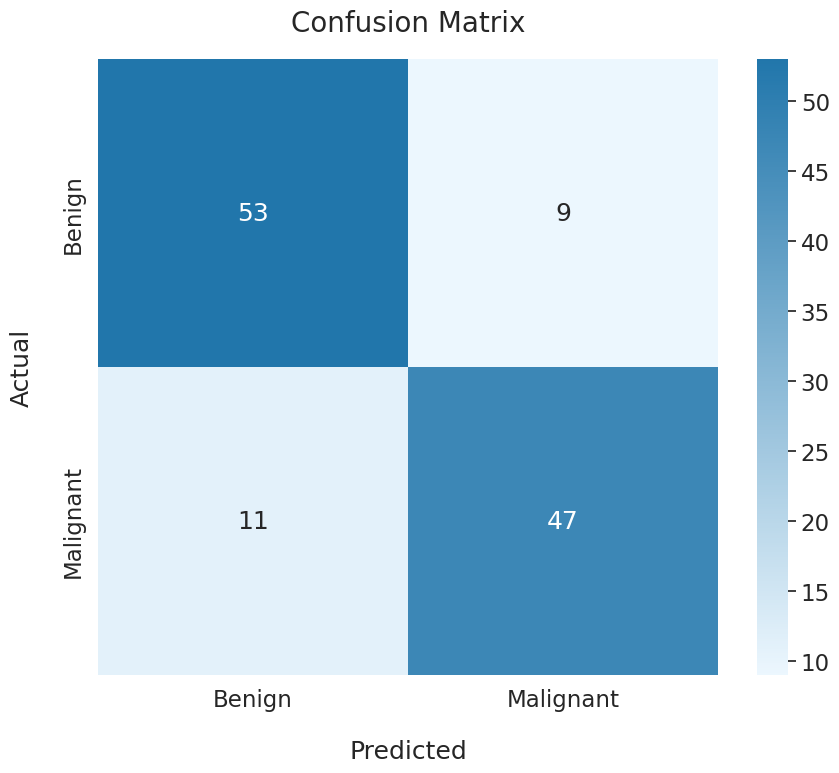

In [21]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = KNeighborsClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc:.2f}')


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=gradient_palette, xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted', labelpad=20)
plt.ylabel('Actual', labelpad=20)
plt.title('Confusion Matrix', pad=20, fontsize=20)
plt.savefig(output_directory + 'knn_confusion_matrix.png')